### Learning the CDF function of table attribute values via Isotonic Regression

In [35]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from scipy.stats import zipf

In [53]:
# Initial data points and their CDF estimates
initial_data = np.array([1.0, 2.0, 3.0])
initial_cdf_values = np.array([0.1, 0.4, 0.7])

# Fit the initial isotonic regression model
cdf_model = IsotonicRegression(increasing=True)
cdf_model.fit(initial_data, initial_cdf_values)

# Function to update the model incrementally
def update_model(cdf_model, new_point, new_cdf_value, predicate_type):
    if predicate_type == "<=":
        # Append the new data point and its CDF value
        updated_data = np.append(cdf_model.X_thresholds_, new_point)
        updated_cdf_values = np.append(cdf_model.y_thresholds_, new_cdf_value)
    elif predicate_type == ">":
        # Convert the "greater than" predicate to a CDF value
        new_cdf_value = 1 - new_cdf_value
        updated_data = np.append(cdf_model.X_thresholds_, new_point)
        updated_cdf_values = np.append(cdf_model.y_thresholds_, new_cdf_value)
    else:
        raise ValueError("Predicate type must be '<=' or '>'")

    # Refit the model with the updated data
    cdf_model.fit(updated_data, updated_cdf_values)


# Function to predict CDF values, with handling for out-of-bounds
def predict_cdf_with_bounds(cdf_model, points):
    predictions = []
    min_data = min(cdf_model.X_thresholds_)
    max_data = max(cdf_model.X_thresholds_)
    
    for point in points:
        if point < min_data:
            predictions.append(0.0)  # CDF is 0 below the minimum
        elif point > max_data:
            predictions.append(1.0)  # CDF is 1 above the maximum
        else:
            predictions.append(cdf_model.predict(np.array([point]))[0])
    
    return np.array(predictions)


"""
def predict_cdf_with_extrapolation(cdf_model, points):
    predictions = []
    x_thresholds = cdf_model.X_thresholds_
    y_thresholds = cdf_model.y_thresholds_
    
    min_data = min(x_thresholds)
    max_data = max(x_thresholds)

    # Calculate slopes for extrapolation
    left_slope = (y_thresholds[1] - y_thresholds[0]) / (x_thresholds[1] - x_thresholds[0])
    right_slope = (y_thresholds[-1] - y_thresholds[-2]) / (x_thresholds[-1] - x_thresholds[-2])

    for point in points:
        if point < min_data:
            # Extrapolate linearly on the left
            extrapolated_value = y_thresholds[0] + left_slope * (point - min_data)
            predictions.append(max(0.0, extrapolated_value))  # Ensure CDF is not negative
        elif point > max_data:
            # Extrapolate linearly on the right
            extrapolated_value = y_thresholds[-1] + right_slope * (point - max_data)
            predictions.append(min(1.0, extrapolated_value))  # Ensure CDF does not exceed 1
        else:
            # Use the model's prediction
            predictions.append(cdf_model.predict(np.array([point]))[0])
    
    return np.array(predictions)
"""

def predict_cdf_with_extrapolation(cdf_model, points):
    predictions = []
    x_thresholds = cdf_model.X_thresholds_
    y_thresholds = cdf_model.y_thresholds_
    
    min_data = min(x_thresholds)
    max_data = max(x_thresholds)

    # Ensure there are enough points to calculate slopes
    if len(x_thresholds) > 1:
        # Calculate slopes for extrapolation
        left_slope = (y_thresholds[1] - y_thresholds[0]) / (x_thresholds[1] - x_thresholds[0])
        right_slope = (y_thresholds[-1] - y_thresholds[-2]) / (x_thresholds[-1] - x_thresholds[-2])
    else:
        # Default slopes if not enough points
        left_slope = 0
        right_slope = 0

    for point in points:
        if point < min_data:
            # Extrapolate linearly on the left
            extrapolated_value = y_thresholds[0] + left_slope * (point - min_data)
            predictions.append(max(0.0, extrapolated_value))  # Ensure CDF is not negative
        elif point > max_data:
            # Extrapolate linearly on the right
            extrapolated_value = y_thresholds[-1] + right_slope * (point - max_data)
            predictions.append(min(1.0, extrapolated_value))  # Ensure CDF does not exceed 1
        else:
            # Use the model's prediction
            predictions.append(cdf_model.predict(np.array([point]))[0])
    
    return np.array(predictions)

In [6]:

# New observations (range predicates and their selectivity)
new_observations = [
    (4.0, 0.8, "<="),  # (new_point, new_cdf_value, predicate_type)
    (5.0, 0.1, ">")
]

# Update the model with each new observation
for new_point, new_cdf_value, predicate_type in new_observations:
    update_model(cdf_model, new_point, new_cdf_value, predicate_type)

# Predict CDF values for a new range
new_range = np.array([2.5, 4.5, 5.5])
predicted_cdf = predict_cdf_with_bounds(cdf_model, new_range)

print("Predicted CDF values:", predicted_cdf)

Predicted CDF values: [0.55 0.85 1.  ]


### Simple example: Learning a uniform distribution

In [10]:
def uniform_pdf(x, a, b):
    if a <= x <= b:
        return 1 / (b - a)
    else:
        return 0.0
    

def uniform_cdf(x, a, b, noise_level=0.0):
    # Calculate the exact CDF value
    if x < a:
        cdf_value = 0.0
    elif x > b:
        cdf_value = 1.0
    else:
        cdf_value = (x - a) / (b - a)
    
    # Add noise if specified
    if noise_level > 0.0:
        noise = np.random.uniform(-noise_level, noise_level)
        cdf_value = np.clip(cdf_value + noise, 0.0, 1.0)
    
    return cdf_value

In [15]:
# Define the domain [a, b]
a, b = 2.0, 5.0

# Generate test values over the domain
x_values = np.linspace(a - 1, b + 1, 100)

# Generate exact CDF values
exact_cdf_values = [uniform_cdf(x, a, b) for x in x_values]

# Simulate noisy CDF data
x_data = np.linspace(a, b, 10)
pdf_values = [uniform_pdf(x, a, b) for x in x_data]
cdf_values = [uniform_cdf(x, a, b) for x in x_data]
noisy_cdf_data = [uniform_cdf(x, a, b, noise_level=0.05) for x in x_data]
noisy_cdf_data = np.clip(noisy_cdf_data, 0, 1)  # Ensure values are between 0 and 1


print("PDF values:", pdf_values)
print("Exact CDF values:", cdf_values)
print("Noisy CDF values:", noisy_cdf_data)

PDF values: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Exact CDF values: [0.0, 0.11111111111111116, 0.22222222222222218, 0.3333333333333333, 0.44444444444444436, 0.5555555555555555, 0.6666666666666666, 0.7777777777777777, 0.8888888888888887, 1.0]
Noisy CDF values: [0.0139921  0.07544644 0.26668911 0.33551817 0.43591064 0.53201112
 0.69409004 0.77339281 0.89573228 0.95187898]


In [16]:
# Fit isotonic regression model on the noisy CDF data
iso_reg = IsotonicRegression(increasing=True)
iso_reg.fit(x_data, noisy_cdf_data)

IsotonicRegression()

In [20]:
def plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step, noisy_data=None):
    plt.figure(figsize=(6, 4))
    plt.plot(x_values, exact_cdf_values, label='Exact CDF', color='blue', linestyle='--')
    plt.plot(x_values, learned_cdf_values, label='Learned CDF', color='red')
    if noisy_data is not None:
        plt.scatter(noisy_data[0], noisy_data[1], color='green', label='Noisy Data Points', zorder=5)
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(f'Comparison of Exact and Learned CDFs - Step {step}')
    plt.legend()
    plt.grid(True)
    plt.show()

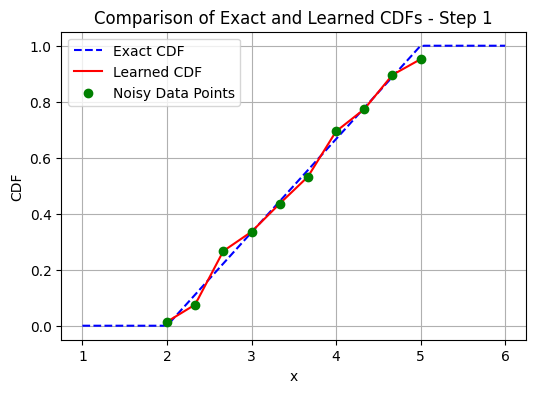

In [21]:
# Predict CDF values using the learned model
learned_cdf_values = iso_reg.predict(x_values)

# Plot the exact and learned CDF values
plot_cdf(x_values, exact_cdf_values, learned_cdf_values, 1, (x_data, noisy_cdf_data))

### Another example: let's start by fitting a model on a small number of initial points which have very high noise. And then incrementally make updates with less noisy data points and at each step, print out a plot to see progress

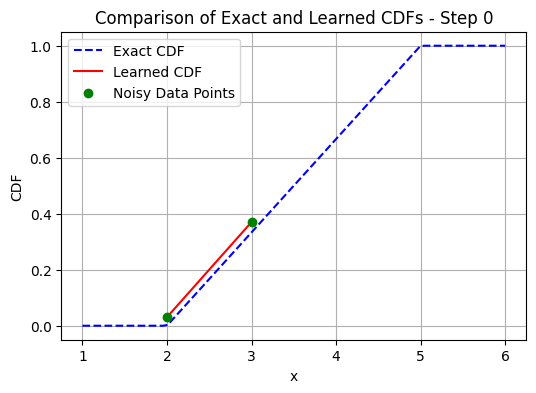

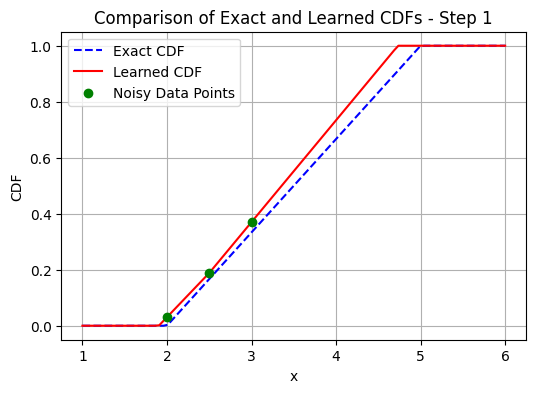

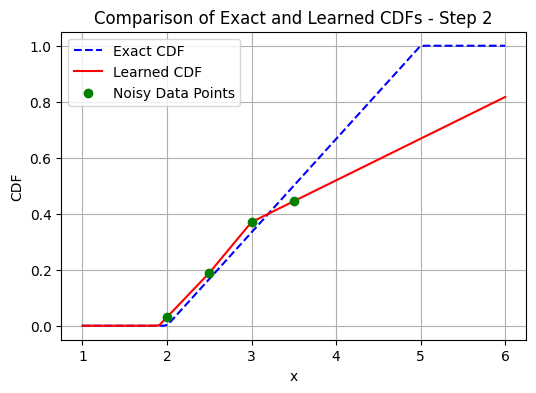

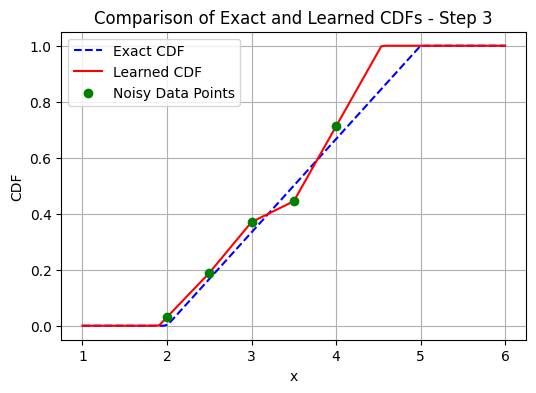

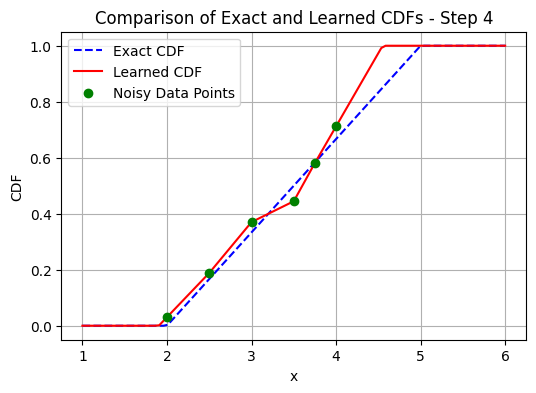

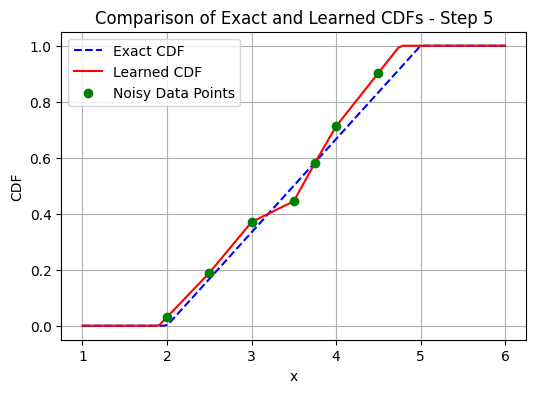

In [34]:
# Define the domain [a, b]
a, b = 2, 5

# Function to generate a noisy CDF value for a single point
def generate_noisy_cdf_data(point, a, b, noise_level):
    return uniform_cdf(point, a, b, noise_level)

# Initialize isotonic regression model
iso_reg = IsotonicRegression(increasing=True)

# Generate test values over the domain
x_values = np.linspace(a - 1, b + 1, 100)
exact_cdf_values = [uniform_cdf(x, a, b) for x in x_values]


# Initial noisy data
initial_points = np.array([2.0, 3.0])
initial_noisy_cdf_values = [generate_noisy_cdf_data(x, a, b, noise_level=0.2) for x in initial_points]

# Fit initial model
iso_reg.fit(initial_points, initial_noisy_cdf_values)

# Initial plot
learned_cdf_values = iso_reg.predict(x_values)
plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=0, noisy_data=(initial_points, initial_noisy_cdf_values))

# Incremental updates with less noisy data
additional_points = np.array([2.5, 3.5, 4.0, 3.75, 4.5, 5.8])
additional_noisy_levels = [0.15, 0.1, 0.05, 0.02, 0.1] # Decreasing noise levels

for step, (new_point, noise_level) in enumerate(zip(additional_points, additional_noisy_levels), start=1):
    new_noisy_cdf_value = generate_noisy_cdf_data(new_point, a, b, noise_level)

    # Update the model with the new point
    all_points = np.append(iso_reg.X_thresholds_, new_point)
    all_cdf_values = np.append(iso_reg.y_thresholds_, new_noisy_cdf_value)
    iso_reg.fit(all_points, all_cdf_values)

    # Predict and plot
    learned_cdf_values = predict_cdf_with_extrapolation(iso_reg, x_values)
    plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=step, noisy_data=(all_points, all_cdf_values))

### More complicated Example: Learning the CDF of a Zipfian PDF

Start with the min and max values of the random variable, then fit an isotonic regression model to these two intial points assuming uniform distribution. Then incrementally learn the CDF of the actual Zipfian PDF 

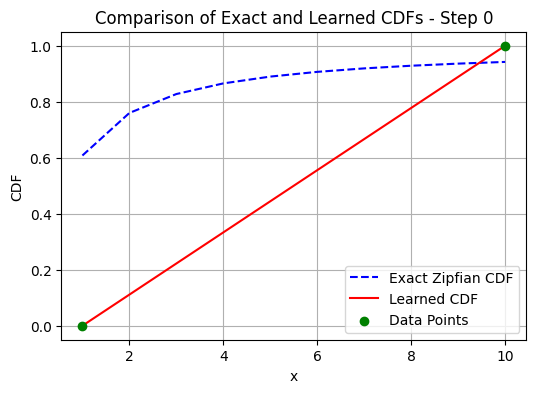

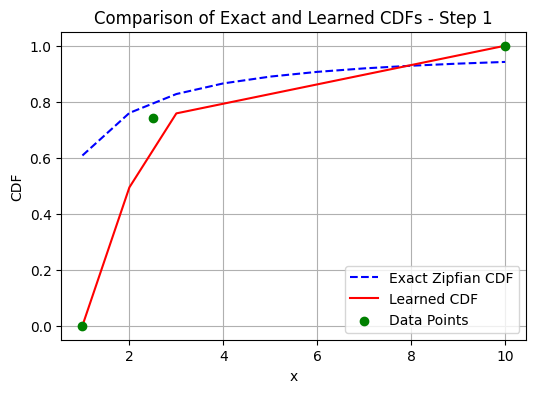

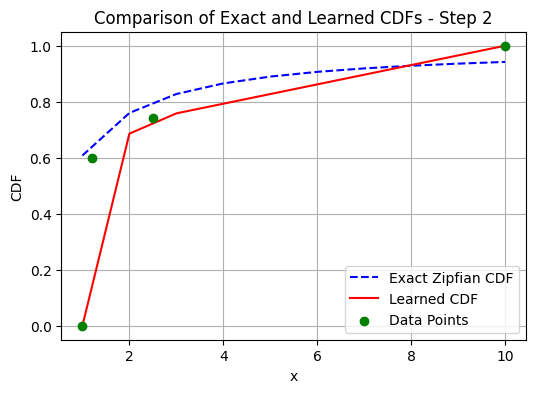

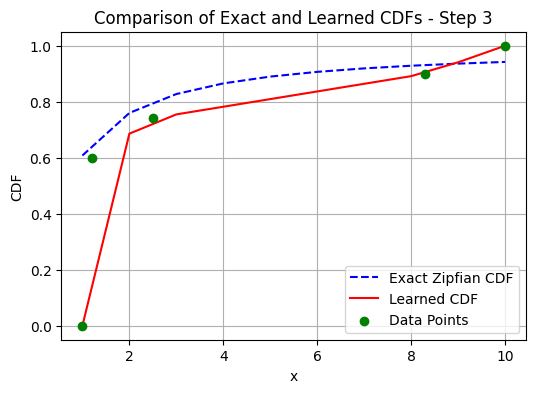

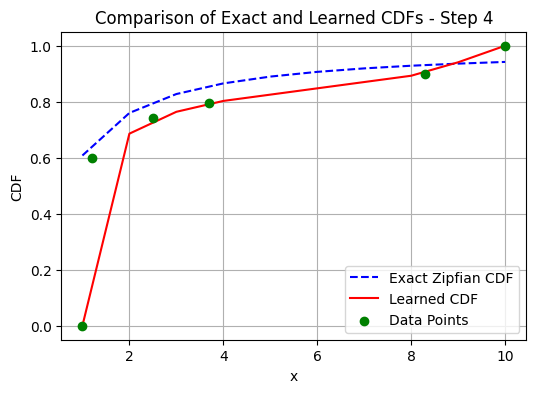

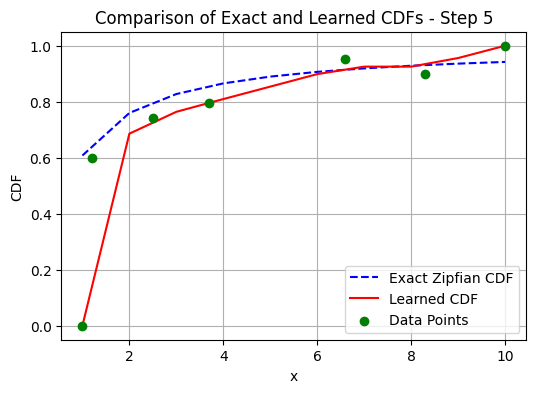

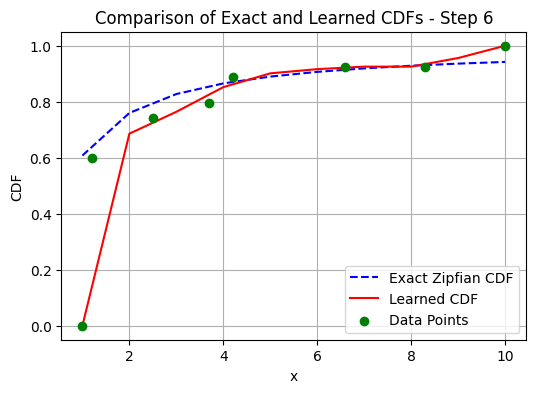

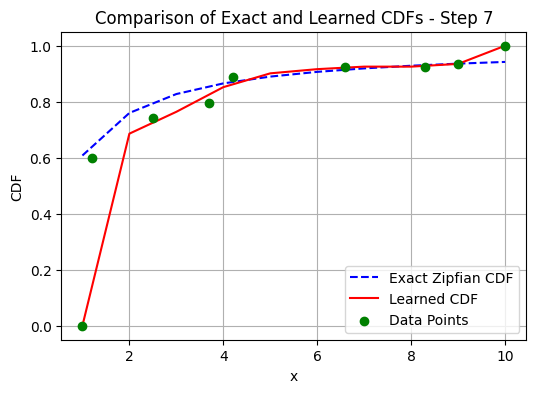

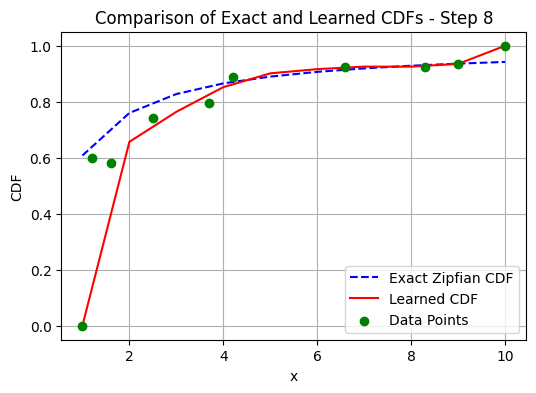

In [51]:
# Define the domain and Zipfian parameter
a, b = 1, 10  # Domain
s = 2  # Zipfian parameter

# Function to calculate the exact Zipfian CDF
def generate_noisy_zipfian_cdf(x, s, N, noise_level=0.0):
    cdf_value = zipf.cdf(x, s)
    noise = np.random.uniform(-noise_level, noise_level)
    return np.clip(cdf_value + noise, 0.0, 1.0)

# Function to plot the exact and learned CDFs
def plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step, noisy_data=None):
    plt.figure(figsize=(6, 4))
    plt.plot(x_values, exact_cdf_values, label='Exact Zipfian CDF', color='blue', linestyle='--')
    plt.plot(x_values, learned_cdf_values, label='Learned CDF', color='red')
    if noisy_data is not None:
        plt.scatter(noisy_data[0], noisy_data[1], color='green', label='Data Points', zorder=5)
    plt.xlabel('x')
    plt.ylabel('CDF')
    plt.title(f'Comparison of Exact and Learned CDFs - Step {step}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Initialize isotonic regression model
iso_reg = IsotonicRegression(increasing=True)

# Generate test values over the domain
x_values = np.arange(a, b + 1)
exact_cdf_values = zipf.cdf(x_values, s)

# Initial uniform data
initial_points = np.array([a, b])
initial_cdf_values = np.array([0.0, 1.0])  # Uniform assumption

# Fit initial model
iso_reg.fit(initial_points, initial_cdf_values)

# Initial plot
learned_cdf_values = iso_reg.predict(x_values)
plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=0, noisy_data=(initial_points, initial_cdf_values))


# Incremental updates with noisy Zipfian data
additional_points = np.array([2.5, 1.2, 8.3, 3.7, 6.6, 4.2, 9.0, 1.6])
noise_level = 0.05  # Adjust noise level as needed

for step, new_point in enumerate(additional_points, start=1):
    new_cdf_value = generate_noisy_zipfian_cdf(new_point, s, b, noise_level)

    # Update the model with the new point
    all_points = np.append(iso_reg.X_thresholds_, new_point)
    all_cdf_values = np.append(iso_reg.y_thresholds_, new_cdf_value)
    iso_reg.fit(all_points, all_cdf_values)

    # Predict and plot
    #learned_cdf_values = iso_reg.predict(x_values)
    learned_cdf_values = predict_cdf_with_extrapolation(iso_reg, x_values)
    plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=step, noisy_data=(all_points, all_cdf_values))




#### This seems to work well, except note that the learned CDF has larger errors near the left boundary. This is due to the starting-point bias from the uniform distribution assumption that we made when training the initial model. To fix this problem, we could try the following:

1) We could remove the initial points after a few iterations
2) We could start without a uniform distribution assumption and just use actual zipfian cdf values just with larger noise

Let's try the first approach.

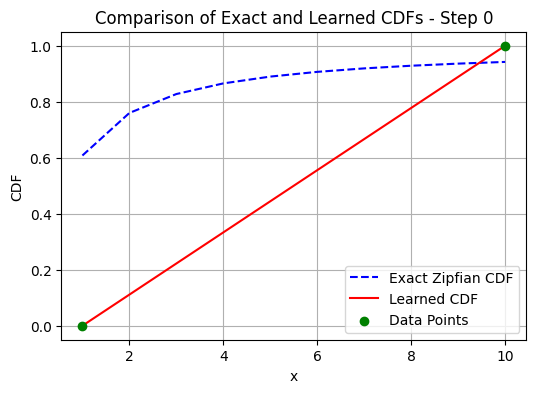

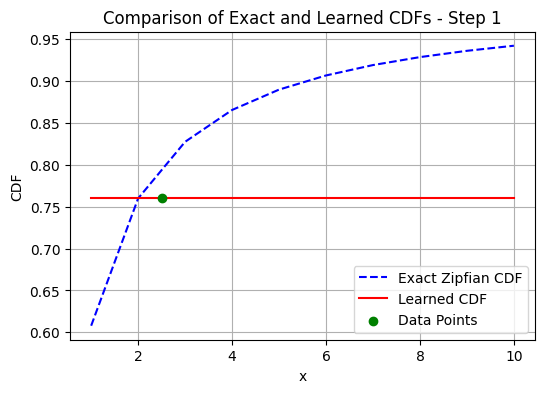

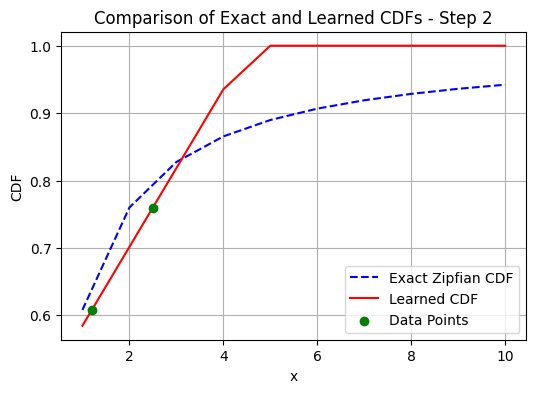

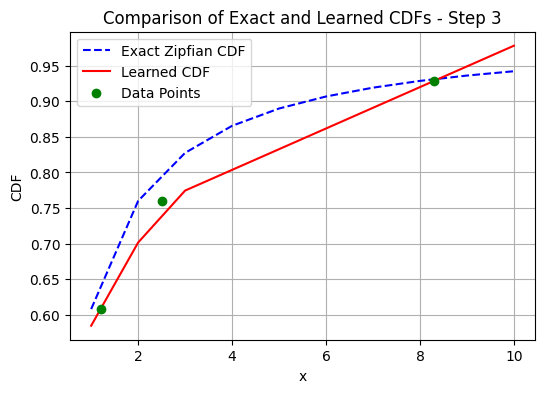

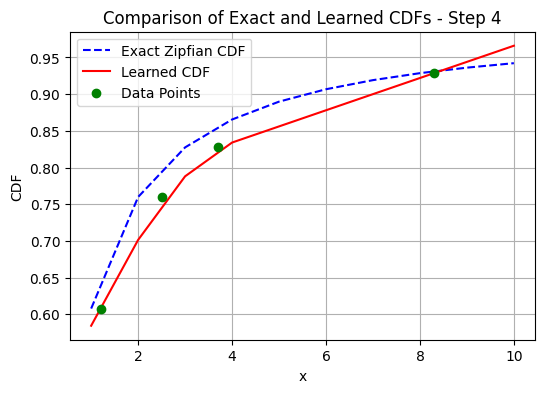

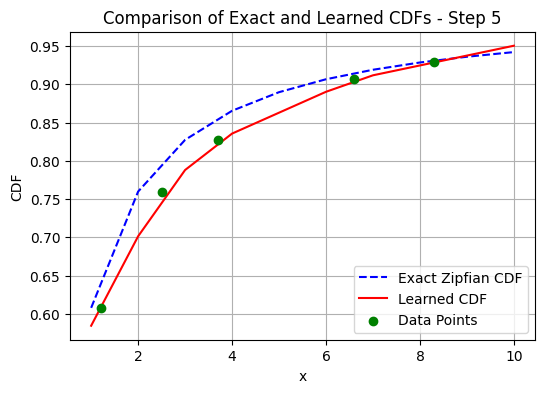

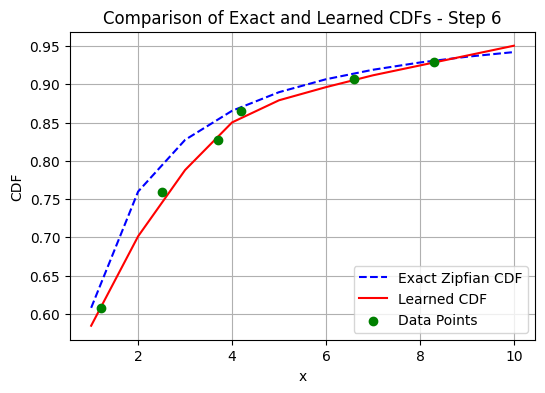

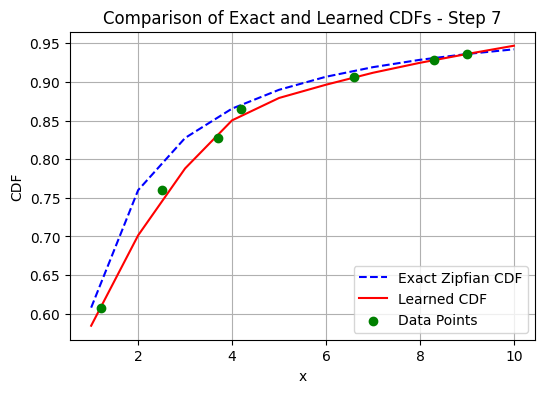

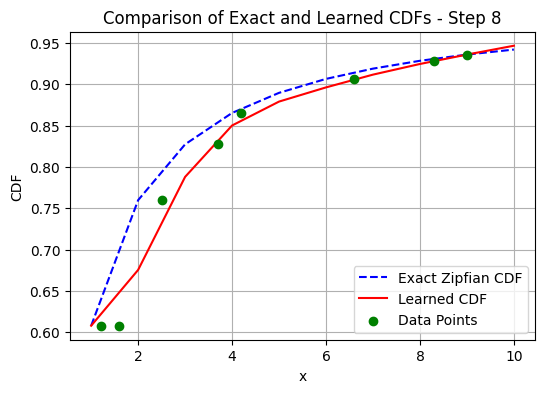

In [54]:
# Generate test values over the domain
x_values = np.arange(a, b + 1)
exact_cdf_values = zipf.cdf(x_values, s)

# Initial uniform data
initial_points = np.array([a, b])
initial_cdf_values = np.array([0.0, 1.0])  # Uniform assumption

# Fit initial model
iso_reg.fit(initial_points, initial_cdf_values)

# Initial plot
learned_cdf_values = iso_reg.predict(x_values)
plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=0, noisy_data=(initial_points, initial_cdf_values))

# Incremental updates with noisy Zipfian data
additional_points = np.array([2.5, 1.2, 8.3, 3.7, 6.6, 4.2, 9.0, 1.6])
noise_level = 0.02  # Adjust noise level as needed

initial_points_removed = False

for step, new_point in enumerate(additional_points, start=1):
    new_cdf_value = generate_noisy_zipfian_cdf(new_point, s, noise_level)

    # Update the model with the new point
    all_points = np.append(iso_reg.X_thresholds_, new_point)
    all_cdf_values = np.append(iso_reg.y_thresholds_, new_cdf_value)
    
    # Remove initial points only once
    if not initial_points_removed and len(all_points) > 2:
        all_points = all_points[2:]
        all_cdf_values = all_cdf_values[2:]
        initial_points_removed = True
    
    iso_reg.fit(all_points, all_cdf_values)

    # Predict and plot
    #learned_cdf_values = iso_reg.predict(x_values)
    learned_cdf_values = predict_cdf_with_extrapolation(iso_reg, x_values)
    plot_cdf(x_values, exact_cdf_values, learned_cdf_values, step=step, noisy_data=(all_points, all_cdf_values))